# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


## Installing and importing functions and packages

In [20]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
#!pip install missingpy

In [44]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from missingpy import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from brats.load_data import load_data

## Loading and splitting data 

In [22]:
# Load data
data = load_data()

# Splitting feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

GBM = FEATURES.loc[LABELS=='GBM']
LGG = FEATURES.loc[LABELS=='LGG']

# Splitting into train and test set --> dit moet weg
#X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=42)



## Preprocessing before crossvalidation

Overview of the NaN's in the dataset

In [24]:
# Determining the number of NaN's
NO_NAN_ROW_TOTAL = FEATURES.isnull().sum(axis=1)             # Number of NaN's per patient for GBM and LGG patients
NO_NAN_COL_TOTAL = FEATURES.isnull().sum(axis=0)             # Number of NaN's per feature for GBM and LGG patients

GBM_NO_NAN_COL = GBM.isnull().sum(axis=0)                    # Number of NaN's per feature for GBM patients
LGG_NO_NAN_COL = LGG.isnull().sum(axis=0)                    # Number of NaN's per feature for LGG patients
OVERVIEW_NAN = { 'Total': NO_NAN_COL_TOTAL, 'GBM': GBM_NO_NAN_COL, 'LGG': LGG_NO_NAN_COL } 


Feature selection based on the number of NaN's. Threshold = the maximum number of NaN's in a column

In [25]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 30
PERC_MISSING_LGG = 30

# Determining threshold for discarding feature based on above percentage
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be discarded to list

for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
DATA_FEAT_SEL = FEATURES.drop(columns=[features for features in set(FEATURES_REMOVED)])

# The variables (series) below 'bins' the NaN's:
# - the index column is the amount of NaN's in the dataset 
# - the second column is the amount of features that have this amount of NaN's

#aantal_NAN_GBM = GBM_no_nan_col.value_counts()
#aantal_NAN_LGG = LGG_no_nan_col.value_counts()
#aantal_NAN_total = no_nan_col.value_counts()


Patient selection based on the number of NaN's. Threshold = the maximum number of NaN's in a row.

In [26]:
# Patient selection 

# Percentage/number of features that a patient is allowed to miss. When above this amount, this patient is removed from the trainingset, because it is missing too many features. 
PERC_MISSING_SAMPLE = 30

# Make the threshold
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(DATA_FEAT_SEL.columns))

# Number of NaN's per patient AFTER removing some features
NO_NAN_ROW_TRAIN = DATA_FEAT_SEL.isnull().sum(axis=1)      

# Make an empty list, which will be filled with samples that are above the threshold
SAMPLES_REMOVED = [] 
LABELS_SEL = LABELS

# Looping over the trainingset to determine which patients are above the threshold, and remove them directly.
#print('These samples are removed from dataset:')
#for sample in NO_NAN_ROW_TRAIN[NO_NAN_ROW_TRAIN > THRESHOLD_SAMPLE].index[:]:
#    if sample:
#        print(sample)
#        SAMPLES_REMOVED.append(sample)      # This should be removed in combination with the comment before
#        DATA_FEAT_SEL = DATA_FEAT_SEL.drop(index=sample)
#        LABELS_SEL = LABELS_SEL.drop(index=sample)

#print(f'{len(DATA_FEAT_SEL)}/{len(FEATURES)} samples are left in dataset')

Evaluation of data distribution and outliers

In [27]:
# Evaluate data distribution: 
IMPUTER_GBM = KNNImputer(n_neighbors=5, weights="uniform")
IMPUTER_LGG = KNNImputer(n_neighbors=5, weights="uniform")        

X_GBM = DATA_FEAT_SEL[LABELS_SEL=='GBM']        
X_IMP_GBM = IMPUTER_GBM.fit_transform(X_GBM)

X_LGG = DATA_FEAT_SEL[LABELS_SEL=='LGG']        
X_IMP_LGG = IMPUTER_LGG.fit_transform(X_LGG)   

NO_NON_NORMAL_GBM = 0
FEAT_NON_NORM_GBM = list()
for index, feature in enumerate(X_IMP_GBM.T):
    t_stat, p_value = shapiro(feature)
    if p_value<0.05:
        NO_NON_NORMAL_GBM += 1 
        FEAT_NON_NORM_GBM.append(index)

NO_NON_NORMAL_LGG = 0
FEAT_NON_NORM_LGG = list()
for index, feature in enumerate(X_IMP_LGG.T):
    t_stat, p_value = shapiro(feature)
    if p_value<0.05:
        NO_NON_NORMAL_LGG += 1 
        FEAT_NON_NORM_LGG.append(index)



C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [8]:

# Evaluate per GBM patient each feature
NO_OUTLIERS_GBM = 0

for patient in X_IMP_GBM:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(X_IMP_GBM[:,index], 25), np.percentile(X_IMP_GBM[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS_GBM += 1

# Evaluate per LGG patient each feature
NO_OUTLIERS_LGG = 0

for patient in X_IMP_LGG:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(X_IMP_LGG[:,index], 25), np.percentile(X_IMP_LGG[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS_LGG += 1

# Calculate mean and standard deviation per feature based on training data
#MEAN = DATA_TOTAL_IMPUTED.mean(axis=0)
#STD = DATA_TOTAL_IMPUTED.std(axis=0)

# Evaluate per patient each feature
#NO_OUTLIERS = 0
#for patient in DATA_TOTAL_IMPUTED:
#    feat_out = 0
#    for feature, mu, std in zip(patient, MEAN, STD):
#        outlier = ((feature>mu+3*std) | (feature<mu-3*std))
#        feat_out += outlier
#    if feat_out > 30:
#        no_outliers += 1

## Function definitions

In [29]:
# Imputation

def knn_impute_train_set(X_train, X_test):
    # Definition of imputers
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    
    # Impute train and test set 
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)
    return X_train_imp, X_test_imp

In [30]:
# Scaling

def scale_train_and_test_data(X_train, X_test):
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scal = scaler.transform(X_train)
    X_test_scal = scaler.transform(X_test)
    return X_train_scal, X_test_scal

In [31]:
# Feature selection using recursive feature elimination

def select_features_rfecv(X_train, y_train):

    svc = svm.SVC(kernel="linear")
    optimal_number_features = list()

    # classifications
    rfecv = RFECV(
        estimator=svc, step=1, 
        cv=StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_train, y_train)                               

    optimal_number_features.append(rfecv.n_features_)
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    return rfecv.support_
    #print(rfecv.ranking_)
    #np.absolute(rfecv.estimator_.coef_)

In [32]:
# Randomized Search for Random Forrest Classifier

def rf_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: Random Forest Classifier with optimal hyperparameters'''

    parameters = {
        'n_estimators': [32, 64, 128, 150],
        'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
        'min_samples_split': [2, 4, 6],
        'max_depth': [1,6,15,28,32]
    }

    grid = RandomizedSearchCV(RandomForestClassifier(), parameters, refit=True, verbose=0, n_iter = 20)
    grid.fit(X_train, y_train)

    rf_classifier = grid.best_estimator_
    #print(rf_classifier)

    return rf_classifier


In [33]:
# Randomized Search for K-Nearest Neighbors Classifier

def knn_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: K-Nearest Neighbors Classifier with optimal hyperparameters'''

    parameters = {  'n_neighbors': list(range(3,31)),
                    'weights': ["uniform", "distance"]
                    }

    grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, refit=True, verbose=0, n_iter = 20)
    grid.fit(X_train, y_train)

    knn_classifier = grid.best_estimator_
    #print(knn_classifier)

    return knn_classifier


In [34]:
# Randomized Search for Support Vector Machine Classifier

def svm_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: SVM Classifier with optimal hyperparameters'''

    parameters =  {'kernel': ['linear', 'rbf', 'poly'],
                    'C': [0.01, 0.1, 1, 10, 100], 
                    'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                    'degree': [1, 2, 3, 4, 5],
                    'coef0': [0.01, 0.5, 1, 5, 10, 20]} 

    grid = RandomizedSearchCV(SVC(), parameters, refit=True, verbose=0, n_iter = 20)

    grid.fit(X_train, y_train)

    svm_classifier = grid.best_estimator_
    #print(svm_classifier)

    return svm_classifier


In [35]:
def get_accuracy_classifier(classifier, X_train, y_train, X_test, y_test):

    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, prediction)
    return accuracy

In [51]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt
    

    



## Crossvalidation 

Run 1 of outer crossvalidation
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
Optimal number of features : 3


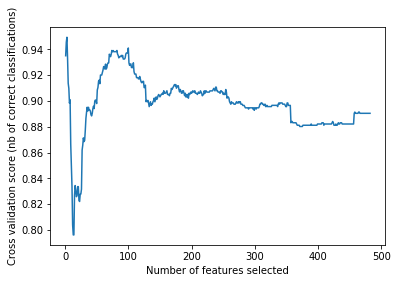

C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning

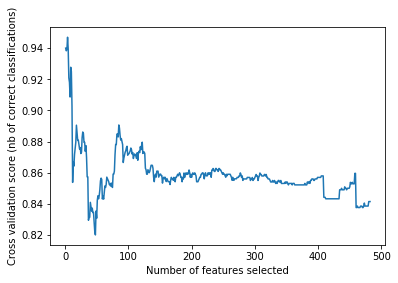

C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
{'SVM': 0.8823529411764706, 'RF': 0.8823529411764706, 'KNN': 0.8823529411764706}
Run 3 of oute

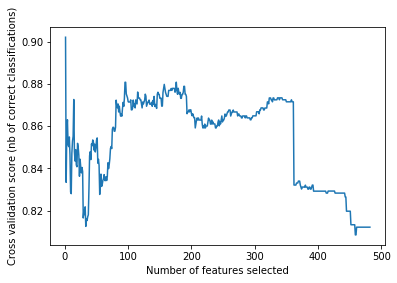

C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
{'SVM': 0.8787878787878788, 'RF': 0.9090909090909091, 'KNN': 0.9090909090909091}
Run 4 of oute

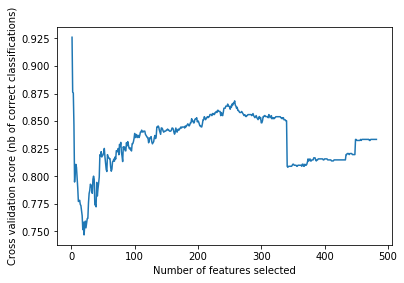

C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
{'SVM': 0.8787878787878788, 'RF': 0.8787878787878788, 'KNN': 0.8787878787878788}
Run 5 of oute

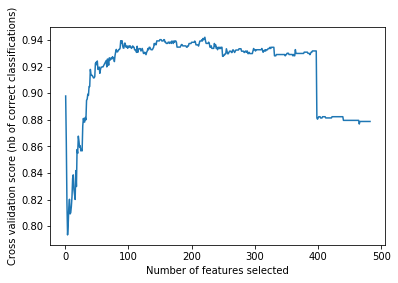

C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
{'SVM': 0.8181818181818182, 'RF': 0.9090909090909091, 'KNN': 0.7272727272727273}
C:\Users\Kiefe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

fold = 0
accuracies_outer = list()

for train_index, test_index in skf.split(DATA_FEAT_SEL, LABELS_SEL):
    fold +=1
    print(f'Run {fold} of outer crossvalidation')
    X_train, X_test = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    y_train, y_test = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]

    gbm_train = X_train[y_train=='GBM']
    lgg_train = X_train[y_train=='LGG']

    # ---------------------------------- IMPUTATION -----------------------------------

    X_train_imp, X_test_imp = knn_impute_train_set(X_train, X_test) 
 
    # ------------------------------------ SCALING ----------------------------------------
    X_train_scal, X_test_scal = scale_train_and_test_data(X_train_imp, X_test_imp)

    # ------------------------------------ FEATURE SELECTION -------------------------------
    selected_features = select_features_rfecv(X_train_scal, y_train)
    X_train_sel = X_train_scal[:,selected_features]
    X_test_sel = X_test_scal[:,selected_features]

    # -------------- INNER CROSSVALIDATION HYPERPARAMETERS---------------------------------
    svm_classifier = svm_randomized_search(X_train_sel, y_train)   

    rf_classifier = rf_randomized_search(X_train_sel, y_train)

    knn_classifier = knn_randomized_search(X_train_sel, y_train)

    clfs = [svm_classifier, rf_classifier, knn_classifier]
    clfs_names = ['SVM', 'RF', 'KNN']

    # ---------------- OUTER CROSSVALIDATION------------------------------------------------
    acc_dict = dict()
    accuracy_total = list()

    for clf, name in zip(clfs, clfs_names):
        acc_dict[name] = get_accuracy_classifier(clf, X_train_sel, y_train, X_test_sel, y_test)
        accuracy_total.append(acc_dict)
    print(acc_dict)
    accuracies_outer.append(accuracy_total)


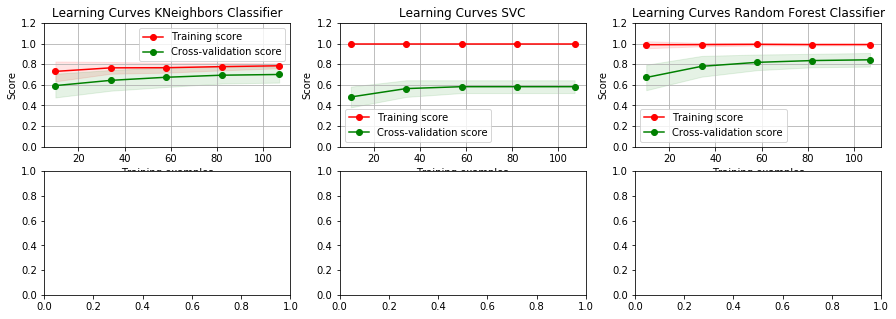

In [77]:
fig, axes = plt.subplots(2,3 , figsize=(15, 5))

title = "Learning Curves KNeighbors Classifier"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0, 1.2),
                    cv=cv, n_jobs=4)

title = "Learning Curves SVC"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0, 1.2),
                    cv=cv, n_jobs=4)

title = "Learning Curves Random Forest Classifier"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 2], ylim=(0, 1.2),
                    cv=cv, n_jobs=4)

plt.show()
